tgb - 6/14/2022 - Polynomial equation discovery for SW radiation, using sequential feature selection to limit the number of terms

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import xarray as xr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

# Data 

## Loading

In [2]:
Nontrop_folder = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/'
Trop_folder = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/tropical_sites/'

#data2018 = xr.open_dataset(Nontrop_folder+'learning_examples_2018.nc')
data2019 = xr.open_dataset(Nontrop_folder+'learning_examples_2019.nc')
data2020 = xr.open_dataset(Nontrop_folder+'learning_examples_2020.nc')

trop2017 = xr.open_dataset(Trop_folder+'learning_examples_2017.nc')

In [3]:
x_train = {}
x_test = {}

In [4]:
data2019['vector_predictor_names']

<xarray.DataArray 'vector_predictor_names' (vector_predictor: 12)>
array([b'pressure_pascals', b'temperature_kelvins',
       b'specific_humidity_kg_kg01', b'liquid_water_content_kg_m03',
       b'ice_water_content_kg_m03', b'liquid_water_path_kg_m02',
       b'ice_water_path_kg_m02', b'vapour_path_kg_m02',
       b'upward_liquid_water_path_kg_m02', b'upward_ice_water_path_kg_m02',
       b'upward_vapour_path_kg_m02', b'relative_humidity_unitless'],
      dtype='|S35')
Dimensions without coordinates: vector_predictor

In [5]:
data2019['scalar_predictor_names']

<xarray.DataArray 'scalar_predictor_names' (scalar_predictor: 6)>
array([b'zenith_angle_radians', b'albedo', b'latitude_deg_n',
       b'longitude_deg_e', b'column_liquid_water_path_kg_m02',
       b'column_ice_water_path_kg_m02'], dtype='|S35')
Dimensions without coordinates: scalar_predictor

In [6]:
print('scalar')
zen_angle2019 = data2019['scalar_predictor_matrix'][:,0].values
zen_angle2020 = data2020['scalar_predictor_matrix'][:,0].values
zen_angle2017 = trop2017['scalar_predictor_matrix'][:,0].values
x_train['cos_za'] = np.concatenate((np.cos(zen_angle2019),np.cos(zen_angle2020)),axis=0)
x_test['cos_za'] = np.cos(zen_angle2017)

albedo2019 = data2019['scalar_predictor_matrix'][:,1].values
albedo2020 = data2020['scalar_predictor_matrix'][:,1].values
albedo2017 = trop2017['scalar_predictor_matrix'][:,1].values
x_train['albedo'] = np.concatenate((albedo2019,albedo2020),axis=0)
x_test['albedo'] = albedo2017
# Replace nan values with "neutral" median values for the albedo
x_train['albedo'][np.isnan(x_train['albedo'])] = np.nanmedian(x_train['albedo'])
x_test['albedo'][np.isnan(x_test['albedo'])] = np.nanmedian(x_test['albedo'])

QLcol = np.concatenate((data2019['scalar_predictor_matrix'][:,-2].values,
                        data2020['scalar_predictor_matrix'][:,-2].values),
                        axis=0)
QLcol2017 = trop2017['scalar_predictor_matrix'][:,-2].values

scalar


In [7]:
for i,key in enumerate(['p','T','qv','ql']):
    print(key)
    x_train[key] = np.concatenate((data2019['vector_predictor_matrix'][:,:,i].values,
                                   data2020['vector_predictor_matrix'][:,:,i].values),axis=0)
    x_test[key] = trop2017['vector_predictor_matrix'][:,:,i].values

p
T
qv
ql


In [8]:
print('vector')
QVup2019 = data2019['vector_predictor_matrix'][:,:,7].values
QVup2020 = data2020['vector_predictor_matrix'][:,:,7].values
QVup = np.concatenate((QVup2019,QVup2020),axis=0)
QVup2017 = trop2017['vector_predictor_matrix'][:,:,7].values
x_train['QVup'] = QVup
x_test['QVup'] = QVup2017

QLup2019 = data2019['vector_predictor_matrix'][:,:,5].values
QLup2020 = data2020['vector_predictor_matrix'][:,:,5].values
QLup = np.concatenate((QLup2019,QLup2020),axis=0)
QLup2017 = trop2017['vector_predictor_matrix'][:,:,5].values
x_train['QLup'] = QLup
x_test['QLup'] = QLup2017

QVdo2019 = data2019['vector_predictor_matrix'][:,:,10].values
QVdo2020 = data2020['vector_predictor_matrix'][:,:,10].values
QVdo = np.concatenate((QVdo2019,QVdo2020),axis=0)
QVdo2017 = trop2017['vector_predictor_matrix'][:,:,10].values
x_train['QVdo'] = QVdo
x_test['QVdo'] = QVdo2017

QVcol = x_train['QVdo'][:,-1]
QVcol2017 = x_test['QVdo'][:,-1]

QLdo2019 = data2019['vector_predictor_matrix'][:,:,8].values
QLdo2020 = data2020['vector_predictor_matrix'][:,:,8].values
QLdo = np.concatenate((QLdo2019,QLdo2020),axis=0)
QLdo2017 = trop2017['vector_predictor_matrix'][:,:,8].values
x_train['QLdo'] = QLdo
x_test['QLdo'] = QLdo2017

RH2019 = data2019['vector_predictor_matrix'][:,:,11].values
RH2020 = data2020['vector_predictor_matrix'][:,:,11].values
RH = np.concatenate((RH2019,RH2020),axis=0)
RH2017 = trop2017['vector_predictor_matrix'][:,:,11].values
x_train['RH'] = RH
x_test['RH'] = RH2017

vector


In [9]:
FSWnet2019_downwards = (data2019['vector_target_matrix'][:,:,0]-data2019['vector_target_matrix'][:,:,1]).values
FSWnet2020_downwards = (data2020['vector_target_matrix'][:,:,0]-data2020['vector_target_matrix'][:,:,1]).values
FSWnet_downwards = np.concatenate((FSWnet2019_downwards,FSWnet2020_downwards),axis=0)
FSWnet2017_downwards = (trop2017['vector_target_matrix'][:,:,0]-trop2017['vector_target_matrix'][:,:,1]).values

In [10]:
# Unitless target
y_train = (FSWnet_downwards/np.outer(FSWnet_downwards[:,-1],np.ones((73,)))).flatten()
y_test = (FSWnet2017_downwards/np.outer(FSWnet2017_downwards[:,-1],np.ones((73,)))).flatten()

In [11]:
FTOA_down_train = np.outer(FSWnet_downwards[:,-1],np.ones((73,))).flatten()
FTOA_down_test = np.outer(FSWnet2017_downwards[:,-1],np.ones((73,))).flatten()

In [12]:
# Converted back to W/m2
Y_train = y_train*FTOA_down_train
Y_test = y_test*FTOA_down_test

In [13]:
x_train['RH'] = np.minimum(1,x_train['RH'])
x_test['RH'] = np.minimum(1,x_test['RH'])

Check the vapor and liquid water paths

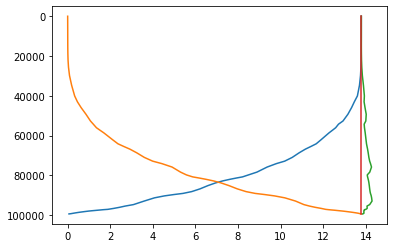

In [15]:
plt.plot(np.mean(x_train['QVdo'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(x_train['QVup'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(x_train['QVup']+x_train['QVdo'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(QVcol,axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0))
# plt.plot(np.mean(x_train['QVdo'][:,-1],axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0),color='k')
# plt.plot(np.mean(x_train['QVup'][:,0],axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0),color='purple')
plt.gca().invert_yaxis()

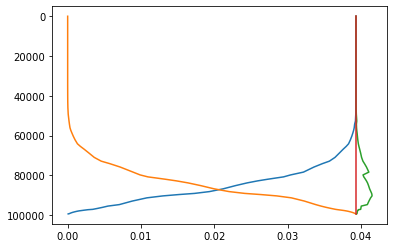

In [16]:
plt.plot(np.mean(x_train['QLdo'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(x_train['QLup'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(x_train['QLup']+x_train['QLdo'],axis=0),np.mean(x_train['p'],axis=0))
plt.plot(np.mean(QLcol,axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0))
# plt.plot(np.mean(x_train['QLdo'][:,-1],axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0),color='k')
# plt.plot(np.mean(x_train['QLup'][:,0],axis=0)*np.ones((73,)),np.mean(x_train['p'],axis=0),color='purple')
plt.gca().invert_yaxis()

Apply correction to conserve liquid and vapor path

In [14]:
QV_excess = x_train['QVdo']+x_train['QVup']-QVcol[:,np.newaxis]
x_train['QVdo'] -= QV_excess/2
x_train['QVup'] -= QV_excess/2
x_train['QVdo'] = np.maximum(x_train['QVdo'],0)
x_train['QVup'] = np.maximum(x_train['QVup'],0)

In [15]:
QL_excess = x_train['QLdo']+x_train['QLup']-QLcol[:,np.newaxis]
x_train['QLdo'] -= QL_excess/2
x_train['QLup'] -= QL_excess/2
x_train['QLdo'] = np.maximum(x_train['QLdo'],0)
x_train['QLup'] = np.maximum(x_train['QLup'],0)

## Pre-processing

In [16]:
scalar_keys = ['cos_za', 'albedo']
vector_keys = ['p', 'T', 'qv', 'ql', 'QVup', 'QLup', 'QVdo', 'QLdo', 'RH']
combin_keys = np.concatenate((scalar_keys,vector_keys))

Normalization

In [17]:
Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}

In [18]:
for keys in combin_keys:
    print(keys)
    Norm['mean'][keys] = np.mean(x_train[keys].flatten())
    Norm['min'][keys] = np.min(x_train[keys].flatten())
    Norm['max'][keys] = np.max(x_train[keys].flatten())
    Norm['std'][keys] = np.std(x_train[keys].flatten())

cos_za
albedo
p
T
qv
ql
QVup
QLup
QVdo
QLdo
RH


In [19]:
Norm

{'mean': {'cos_za': 0.41197172,
  'albedo': 0.36450702,
  'p': 61282.285,
  'T': 258.21127,
  'qv': 0.0023409505,
  'ql': 6.7758633e-06,
  'QVup': 5.368949,
  'QLup': 0.013895888,
  'QVdo': 8.422303,
  'QLdo': 0.025450327,
  'RH': 0.4829557},
 'min': {'cos_za': 0.08715853,
  'albedo': 0.0,
  'p': 57.200005,
  'T': 190.39284,
  'qv': 0.0,
  'ql': 0.0,
  'QVup': 4.4537655e-06,
  'QLup': 0.0,
  'QVdo': 0.0,
  'QLdo': 0.0,
  'RH': 0.0},
 'max': {'cos_za': 0.9814883,
  'albedo': 1.0,
  'p': 104376.76,
  'T': 313.61823,
  'qv': 0.023318946,
  'ql': 0.0022818162,
  'QVup': 68.94789,
  'QLup': 3.5342865,
  'QVdo': 68.97026,
  'QLdo': 3.5342865,
  'RH': 1.0},
 'std': {'cos_za': 0.22024997,
  'albedo': 0.2811299,
  'p': 35467.44,
  'T': 23.735064,
  'qv': 0.0029519943,
  'ql': 3.8062775e-05,
  'QVup': 7.314085,
  'QLup': 0.06789491,
  'QVdo': 8.415417,
  'QLdo': 0.085250154,
  'RH': 0.35313952}}

In [20]:
x_train_std = {}
x_train_range = {}

In [21]:
for key in scalar_keys:
    x_train[key] = np.outer(x_train[key],np.ones((73,)))
    x_test[key] = np.outer(x_test[key],np.ones((73,)))

In [22]:
for key in combin_keys:
    x_train_std[key] = (x_train[key].flatten()-Norm['mean'][key])/Norm['std'][key]
    x_train_range[key] = (x_train[key].flatten()-Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])

In [23]:
x_test_std = {}
x_test_range = {}

for key in combin_keys:
    x_test_std[key] = (x_test[key].flatten()-Norm['mean'][key])/Norm['std'][key]
    x_test_range[key] = (x_test[key].flatten()-Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])

Check the distribution shape to assess whether it's most appropriate to normalize using the Z-score or the range

In [ ]:
for key in combin_keys:
    fig = plt.figure(figsize=(15,3))
    plt.ylabel(key)
    plt.hist(x_train_std[key],bins=100);

In [ ]:
for key in combin_keys:
    fig = plt.figure(figsize=(15,3))
    plt.ylabel(key)
    plt.hist(x_train_range[key],bins=100);

It seems that the range normalization is most appropriate!

Given their distributions, it could be more appropriate to use the log of the liquid/vapor water paths

# Polynomial fit + Sequential feature selection

In [24]:
x_train_range.keys()

dict_keys(['cos_za', 'albedo', 'p', 'T', 'qv', 'ql', 'QVup', 'QLup', 'QVdo', 'QLdo', 'RH'])

In [25]:
key_array = ['cos_za', 'albedo', 'p', 'T', 'qv', 'ql', 'QVup', 'QLup', 'QVdo', 'QLdo', 'RH']

In [26]:
X_train = np.zeros((x_train_range['T'].shape[0],len(x_train_range.keys())))
X_test = np.zeros((x_test_range['T'].shape[0],len(x_test_range.keys())))

In [27]:
X_train.shape

(109434081, 11)

In [28]:
for ikey,key in enumerate(x_train_range.keys()):
    print(key)
    X_train[:,ikey] = x_train_range[key]
    X_test[:,ikey] = x_test_range[key]

cos_za
albedo
p
T
qv
ql
QVup
QLup
QVdo
QLdo
RH


The code below is mostly borrowed/slightly adapted from Arthur Grundner (DLR)

In [29]:
save_folder = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/Polynomial_Fits/'

## Linear (degree 1)

In [33]:
cv = 2
min_features_to_select = 1
max_features_to_select = 11

In [34]:
dict_combined = {}

In [35]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train, y_train)
    selected_features = np.array(key_array)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train)

#     Arthur: Plot coefficient variability
#     cv_model = cross_validate(
#         lin_reg,
#         X_transformed,
#         y_train,
#         cv=RepeatedKFold(n_splits=cv, n_repeats=cv),
#         return_estimator=True,
#         n_jobs=-1,
#     )

#     coefs = pd.DataFrame(
#         [
#             est.coef_
#             for est in cv_model["estimator"]
#         ],
#         columns=selected_features,
#     )
    # Loss of the optimal multiple linear regression model trained on transformed data
    lin_reg.fit(X_transformed, y_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(y_train, ypred)
    
    ypred_test = lin_reg.predict(sfs.transform(X_test))
    mse_test = mean_squared_error(y_test, ypred_test)
    
    # Convert back to W/m2
    Ypred = ypred*FTOA_down_train; 
    Ypred_test = ypred_test*FTOA_down_test; 
    MSE_train = mean_squared_error(Y_train,Ypred)
    MSE_test = mean_squared_error(Y_test,Ypred_test)
    
    # Output function and its R2-score
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    dict_exp['MSE_train'] = MSE_train
    dict_exp['MSE_test'] = MSE_test
    print(dict_exp)
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['RH']
{'RH': -0.4147052418795943, 'LR_Bias': 0.9211266892175056, 'mse_train': 0.021150359181792238, 'mse_test': 0.022295132286430538, 'MSE_train': 4464.48375028484, 'MSE_test': 15827.999139208654}
Features selected by forward sequential selection: ['albedo', 'RH']
{'albedo': -0.21283922804424255, 'RH': -0.40494904312976515, 'LR_Bias': 0.9939962849823085, 'mse_train': 0.017581945652581702, 'mse_test': 0.01501906736367158, 'MSE_train': 2819.4809830174345, 'MSE_test': 8183.35398318683}
Features selected by forward sequential selection: ['albedo', 'QLup', 'RH']
{'albedo': -0.23381680089961518, 'QLup': -3.588355214610685, 'RH': -0.35228899808247194, 'LR_Bias': 0.990318834471834, 'mse_train': 0.0131980844606986, 'mse_test': 0.009620374999130314, 'MSE_train': 1949.0602256679674, 'MSE_test': 5067.613004090682}
Features selected by forward sequential selection: ['albedo', 'p', 'QLup', 'RH']
{'albedo': -0.24715900004718955, 'p': -0.242441596329

In [36]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_14_deg1_cv'+str(cv)
pkl.dump(dict_combined, open(save_path,'wb'))

## Quadratic (degree 2)

### Sequential Feature Selector

In [30]:
cv = 2
deg = 2
min_features_to_select = 1
max_features_to_select = 10

In [31]:
poly = PolynomialFeatures(degree=deg)
X_train2 = poly.fit_transform(X_train)

if deg == 2:
    assert X_train2.shape[1] == 1 + len(key_array)/2*(len(key_array)+3)
    
print(X_train2.shape[1])
    
new_features = poly.get_feature_names(np.array(key_array)) # Update the feature names
X_test2 = poly.fit_transform(X_test)

78


/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/miniconda3/envs/ml4rt/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
new_features

['1',
 'cos_za',
 'albedo',
 'p',
 'T',
 'qv',
 'ql',
 'QVup',
 'QLup',
 'QVdo',
 'QLdo',
 'RH',
 'cos_za^2',
 'cos_za albedo',
 'cos_za p',
 'cos_za T',
 'cos_za qv',
 'cos_za ql',
 'cos_za QVup',
 'cos_za QLup',
 'cos_za QVdo',
 'cos_za QLdo',
 'cos_za RH',
 'albedo^2',
 'albedo p',
 'albedo T',
 'albedo qv',
 'albedo ql',
 'albedo QVup',
 'albedo QLup',
 'albedo QVdo',
 'albedo QLdo',
 'albedo RH',
 'p^2',
 'p T',
 'p qv',
 'p ql',
 'p QVup',
 'p QLup',
 'p QVdo',
 'p QLdo',
 'p RH',
 'T^2',
 'T qv',
 'T ql',
 'T QVup',
 'T QLup',
 'T QVdo',
 'T QLdo',
 'T RH',
 'qv^2',
 'qv ql',
 'qv QVup',
 'qv QLup',
 'qv QVdo',
 'qv QLdo',
 'qv RH',
 'ql^2',
 'ql QVup',
 'ql QLup',
 'ql QVdo',
 'ql QLdo',
 'ql RH',
 'QVup^2',
 'QVup QLup',
 'QVup QVdo',
 'QVup QLdo',
 'QVup RH',
 'QLup^2',
 'QLup QVdo',
 'QLup QLdo',
 'QLup RH',
 'QVdo^2',
 'QVdo QLdo',
 'QVdo RH',
 'QLdo^2',
 'QLdo RH',
 'RH^2']

In [33]:
dict_combined = {}

In [36]:
# Randomly sub-sample X_train2 without replacement for sfs (not training nor evaluation)
Nsample = 10000000
i_random = np.random.choice(np.linspace(0,X_train2.shape[0]-1,X_train2.shape[0]),
                            size=((Nsample,)),replace=False).astype('int')
X_train2_sub = X_train2[i_random,:]
y_train_sub = y_train[i_random,]

In [37]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train2_sub, y_train_sub)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train2)
    lin_reg.fit(X_transformed, y_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(y_train, ypred)
    
    ypred_test = lin_reg.predict(sfs.transform(X_test2))
    mse_test = mean_squared_error(y_test, ypred_test)
    
    # Convert back to W/m2
    Ypred = ypred*FTOA_down_train; 
    Ypred_test = ypred_test*FTOA_down_test; 
    MSE_train = mean_squared_error(Y_train,Ypred)
    MSE_test = mean_squared_error(Y_test,Ypred_test)
    
    # Output function and its R2-score
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    dict_exp['MSE_train'] = MSE_train
    dict_exp['MSE_test'] = MSE_test
    print(dict_exp)
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['p RH']
{'p RH': -0.4822371075886469, 'LR_Bias': 0.9024821048861624, 'mse_train': 0.019045881166397226, 'mse_test': 0.02305905874580787, 'MSE_train': 4252.377810017608, 'MSE_test': 16932.563629416636}
Features selected by forward sequential selection: ['albedo p', 'p RH']
{'albedo p': -0.36290607799167657, 'p RH': -0.3466544418977361, 'LR_Bias': 0.9291008867632446, 'mse_train': 0.014017602296756176, 'mse_test': 0.012883831906316642, 'MSE_train': 2210.1660410686263, 'MSE_test': 6578.787454431785}
Features selected by forward sequential selection: ['QLup', 'albedo p', 'p RH']
{'QLup': -3.641926667435071, 'albedo p': -0.4171100876698867, 'p RH': -0.2606237167554728, 'LR_Bias': 0.9226191598526184, 'mse_train': 0.009673216466121971, 'mse_test': 0.007472683035776107, 'MSE_train': 1342.1160565315229, 'MSE_test': 3252.7810342298767}
Features selected by forward sequential selection: ['QLup', 'albedo p', 'p QLdo', 'p RH']
{'QLup': -3.438455475

In [38]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_14_deg2_cv'+str(cv)
pkl.dump(dict_combined, open(save_path,'wb'))

### Use everything

In [ ]:
lin_reg.fit(X_train2, y_train)
ypred = lin_reg.predict(X_train2)
mse_train = mean_squared_error(y_train, ypred)

ypred_test = lin_reg.predict(X_test2)
mse_test = mean_squared_error(y_test, ypred_test)

# Convert back to W/m2
Ypred = ypred*FTOA_down_train; 
Ypred_test = ypred_test*FTOA_down_test; 
MSE_train = mean_squared_error(Y_train,Ypred)
MSE_test = mean_squared_error(Y_test,Ypred_test)

# Output function and its R2-score
dict_exp = {}
for i in range(len(selected_features)):
    dict_exp[selected_features[i]] = lin_reg.coef_[i]
dict_exp['LR_Bias'] = lin_reg.intercept_
dict_exp['mse_train'] = mse_train
dict_exp['mse_test'] = mse_test
dict_exp['MSE_train'] = MSE_train
dict_exp['MSE_test'] = MSE_test
print(dict_exp)

In [ ]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_14_deg2_all_cv'+str(cv)
pkl.dump(dict_exp, open(save_path,'wb'))

## Cubic (degree 3)

In [ ]:
cv = 2
deg = 3
min_features_to_select = 1
max_features_to_select = 10

In [ ]:
poly = PolynomialFeatures(degree=deg)
X_train3 = poly.fit_transform(X_train)

print(X_train3.shape[1])
    
new_features = poly.get_feature_names(np.array(key_array)) # Update the feature names
X_test3 = poly.fit_transform(X_test)

In [ ]:
new_features

### Sequential Feature Selector

In [ ]:
dict_combined = {}

In [ ]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train3, y_train)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train3)
    lin_reg.fit(X_transformed, y_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(y_train, ypred)
    
    ypred_test = lin_reg.predict(sfs.transform(X_test3))
    mse_test = mean_squared_error(y_test, ypred_test)
    
    # Convert back to W/m2
    Ypred = ypred*FTOA_down_train; 
    Ypred_test = ypred_test*FTOA_down_test; 
    MSE_train = mean_squared_error(Y_train,Ypred)
    MSE_test = mean_squared_error(Y_test,Ypred_test)
    
    # Output function and its R2-score
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    dict_exp['MSE_train'] = MSE_train
    dict_exp['MSE_test'] = MSE_test
    print(dict_exp)
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

In [ ]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_14_deg3_cv'+str(cv)
pkl.dump(dict_combined, open(save_path,'wb'))

### Use everything

In [ ]:
lin_reg.fit(X_train3, y_train)
ypred = lin_reg.predict(X_train3)
mse_train = mean_squared_error(y_train, ypred)

ypred_test = lin_reg.predict(X_test3)
mse_test = mean_squared_error(y_test, ypred_test)

# Convert back to W/m2
Ypred = ypred*FTOA_down_train; 
Ypred_test = ypred_test*FTOA_down_test; 
MSE_train = mean_squared_error(Y_train,Ypred)
MSE_test = mean_squared_error(Y_test,Ypred_test)

# Output function and its R2-score
dict_exp = {}
for i in range(len(selected_features)):
    dict_exp[selected_features[i]] = lin_reg.coef_[i]
dict_exp['LR_Bias'] = lin_reg.intercept_
dict_exp['mse_train'] = mse_train
dict_exp['mse_test'] = mse_test
dict_exp['MSE_train'] = MSE_train
dict_exp['MSE_test'] = MSE_test
print(dict_exp)

In [ ]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_14_deg3_all_cv'+str(cv)
pkl.dump(dict_exp, open(save_path,'wb'))